In [1]:
import os,shutil,tqdm
import cv2,re
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
current_path = f'H:\\NCNU\\class\\111-2_code\\2.DL\\111-2 DL HW\\TermProject'
traindata_path = f'{current_path}/train'
train_csv_path = f'{current_path}/train.csv'
train = pd.read_csv(train_csv_path)
train

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN
115484,case30_day0_slice_0143,stomach,NaN
115485,case30_day0_slice_0144,large_bowel,NaN
115486,case30_day0_slice_0144,small_bowel,NaN


In [3]:
#過濾掉segmentation為nan欄位
train = train.dropna(subset=['segmentation'])
train = train.reset_index(drop=True)
train

,id,class,segmentation
0,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
1,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...
2,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...
3,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...
4,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...
...,...,...,...
33908,case30_day0_slice_0135,small_bowel,22540 1 22804 5 23069 7 23334 10 23600 11 2386...
33909,case30_day0_slice_0136,large_bowel,18746 7 19009 23 19038 7 19273 44 19537 49 198...
33910,case30_day0_slice_0136,small_bowel,23079 1 23343 6 23608 9 23874 11 24139 13 2440...
33911,case30_day0_slice_0137,large_bowel,18746 2 19010 8 19040 3 19274 25 19302 12 1953...


In [4]:
#取出目前要segmentation的3個部位
classes = train.loc[:, 'class'].unique().tolist()
print(classes)

['stomach', 'large_bowel', 'small_bowel']


In [5]:
#依照把3行欄位('stomach', 'large_bowel', 'small_bowel')化減成一行(因3segmentation部位是分別標記的,所以一張影像有3個欄位)
train_df_grouped = train.copy()
train_df_grouped.set_index('id', inplace = True)
seg_list = []
for cl in classes:
    seg = train_df_grouped[train_df_grouped['class'] == cl]['segmentation']
    seg.name = cl
    seg_list.append(seg)

In [6]:
train_df_grouped = pd.concat(seg_list, axis=1).reset_index()
train_df_grouped.fillna('', inplace = True)
train_df_grouped.head()

,id,stomach,large_bowel,small_bowel
0,case123_day20_slice_0065,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,,
1,case123_day20_slice_0066,27561 8 27825 11 28090 13 28355 14 28620 15 28...,,
2,case123_day20_slice_0067,15323 4 15587 8 15852 10 16117 11 16383 12 166...,,
3,case123_day20_slice_0068,14792 5 15056 9 15321 11 15587 11 15852 13 161...,,
4,case123_day20_slice_0069,14526 6 14789 12 15054 14 15319 16 15584 17 15...,,


In [7]:
def get_case_day_slice(x):
    #--------------------------------------------------------------------------------------
    # function that parses a string (full_path or image_id)
    # and returns case, day, slice_ 
    #--------------------------------------------------------------------------------------
    case = re.search('case[0-9]+', x).group()[len('case'):]
    day = re.search('day[0-9]+', x).group()[len('day'):]
    slice_ = re.search('slice_[0-9]+', x).group()[len('slice_'):]
    return case, day, slice_

In [8]:
def process_df(df, path):
    #--------------------------------------------------------------------------------------
    # add new columns:
    # ['case', 'day', 'slice_']
    # and
    # 'full_path'
    #--------------------------------------------------------------------------------------
    case_day_slice = ['case', 'day', 'slice_']
    df = df.copy()
    df.loc[:, case_day_slice] = df.id.apply(get_case_day_slice).to_list()
    
    # get list of all images 
    all_images = glob(os.path.join(path, "**", "*.png"), recursive = True)
    img_df = pd.DataFrame(all_images, columns = ['full_path'])
    img_df.loc[:, case_day_slice] = img_df.full_path.apply(get_case_day_slice).to_list()
    
    return df.merge(img_df, on = case_day_slice, how = 'left')

In [9]:
train_df_grouped = process_df(train_df_grouped, traindata_path)
print(len(train_df_grouped))
train_df_grouped.head()

16590


,id,stomach,large_bowel,small_bowel,case,day,slice_,full_path
0,case123_day20_slice_0065,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,,,123,20,0065,H:\NCNU\class\111-2_code\2.DL\111-2 DL HW\Term...
1,case123_day20_slice_0066,27561 8 27825 11 28090 13 28355 14 28620 15 28...,,,123,20,0066,H:\NCNU\class\111-2_code\2.DL\111-2 DL HW\Term...
2,case123_day20_slice_0067,15323 4 15587 8 15852 10 16117 11 16383 12 166...,,,123,20,0067,H:\NCNU\class\111-2_code\2.DL\111-2 DL HW\Term...
3,case123_day20_slice_0068,14792 5 15056 9 15321 11 15587 11 15852 13 161...,,,123,20,0068,H:\NCNU\class\111-2_code\2.DL\111-2 DL HW\Term...
4,case123_day20_slice_0069,14526 6 14789 12 15054 14 15319 16 15584 17 15...,,,123,20,0069,H:\NCNU\class\111-2_code\2.DL\111-2 DL HW\Term...


In [10]:
train_df_grouped = train_df_grouped[(train_df_grouped['case'] != 7) | (train_df_grouped['day'] != 0)].reset_index(drop = True)
train_df_grouped = train_df_grouped[(train_df_grouped['case'] != 81) | (train_df_grouped['day'] != 30)].reset_index(drop = True)
train_df_grouped.to_csv('train_df_grouped.csv',index=False)

In [11]:
def RLE_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
"""
def RLE_decoder(rle,shape):
    '''
    run-length encoding將二進位圖像中的像素值序列壓縮的技術,醫學影像中,RLE通常用於編碼二進位,節省空間並方便傳輸
    '''
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)
"""
def RLE_decoder(rle, shape , fill=1):
    '''
    run-length encoding將二進位圖像中的像素值序列壓縮的技術,醫學影像中,RLE通常用於編碼二進位,節省空間並方便傳輸
    '''
    width, height = shape
    s = rle.split()
    start, length = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    start -= 1
    mask = np.zeros(height*width, dtype=np.uint8)
    for i, l in zip(start, length):
        mask[i:i+l] = fill
    mask = mask.reshape(width,height)
    mask = np.ascontiguousarray(mask)
    return mask

mask有大腸large_bowel: 14085
mask有小腸small_bowel: 11201
mask有胃stomach: 8627


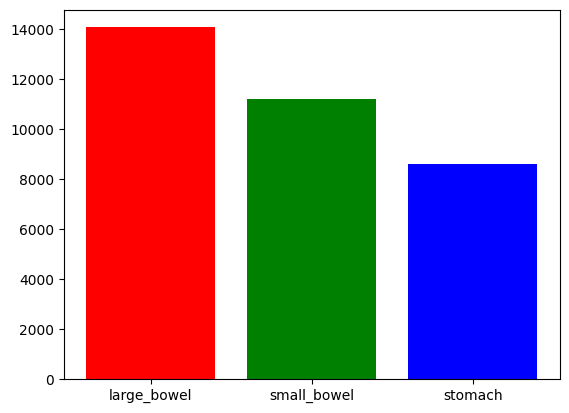

In [12]:
large_bowel_df = len(train_df_grouped[train_df_grouped.large_bowel != ''])
small_bowel_df	= len(train_df_grouped[train_df_grouped.small_bowel != ''])
stomach_df = len(train_df_grouped[train_df_grouped.stomach != ''])
print('mask有大腸large_bowel:',large_bowel_df)
print('mask有小腸small_bowel:',small_bowel_df)
print('mask有胃stomach:',stomach_df)
plt.bar(['large_bowel','small_bowel','stomach'],[large_bowel_df,small_bowel_df,stomach_df],color=['red', 'green', 'blue'])
plt.show()

(266, 266)
(266, 266)
(266, 266)
(310, 360)
(310, 360)
(310, 360)


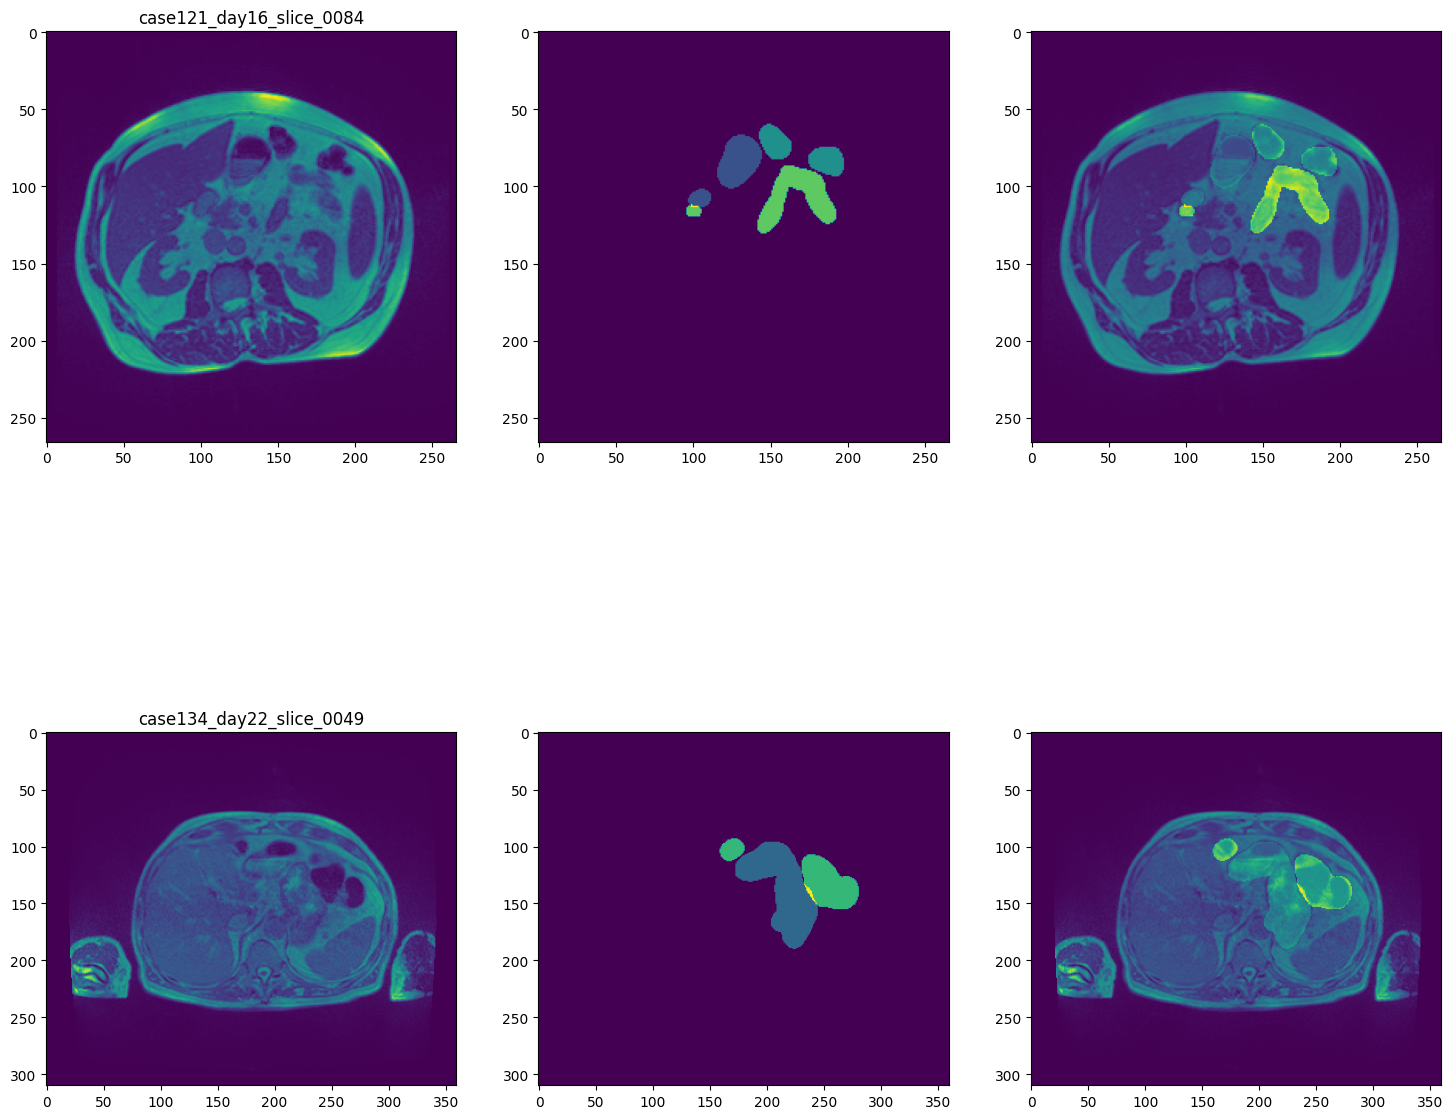

In [13]:
num = 2
#從mask欄位sample出stomach的mask不為空的case
segmentation_df_example = train_df_grouped[ train_df_grouped.stomach != ''].sample(num)
segmentation_df_example
fig, ax = plt.subplots(num, 3, figsize=(18, 8*num))
for i in range(num):
    record = segmentation_df_example.iloc[i, :]
    
    #img = mpimg.imread(record.full_path, format = 'png')
    img = cv2.imread(record.full_path,cv2.IMREAD_GRAYSCALE)
    ax[i, 0].imshow(img)
    ax[i, 0].set_title(record.id)
    cv2.imwrite(f'origin.png',img)
    mask = np.zeros(img.shape)
    for j, cl in enumerate(classes):
        #mm = RLE_decoder(record[cl], img.shape)*255
        mm2 = RLE_decoder(record[cl], img.shape , fill=1)*255
        print(mm2.shape)
        cv2.imwrite(f'{cl}.png',mm2)
        
        mask += RLE_decoder(record[cl], img.shape)*(j + 1) / 4 * np.max(img)
    cv2.imwrite(f'merge.png',mask)
    
    plt.savefig(f'{current_path}/mask.png')
    ax[i, 1].imshow(mask)
    ax[i, 2].imshow(img + mask)


large_bowel + small_bowel + stomach: 3201

large_bowel + small_bowel: 7781

large_bowel + stomach: 2980

small_bowel + stomach: 160

only_large_bowel: 123

only_small_bowel: 59

only_stomach: 2286

total: 16590


large_bowel + small_bowel + stomach: 3201
large_bowel + small_bowel: 7781
large_bowel + stomach: 2980
small_bowel + stomach: 160
only_large_bowel: 123
only_small_bowel: 59
only_stomach: 2286
total: 16590


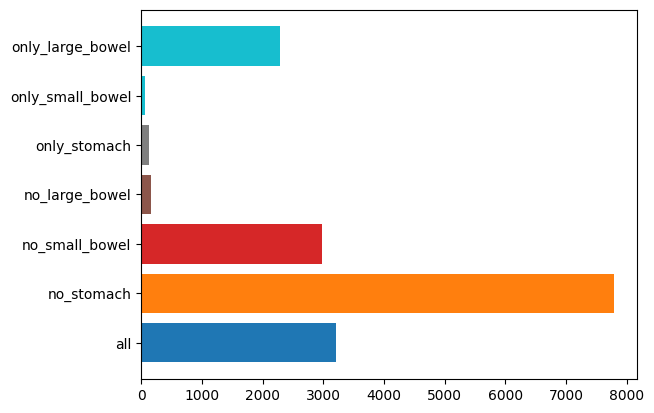

In [14]:
large_bowel_small_bowel_stomach = train_df_grouped.loc[(train_df_grouped['large_bowel'] != '') & (train_df_grouped['small_bowel'] != '') & (train_df_grouped['stomach'] != '')]
print('large_bowel + small_bowel + stomach:',len(large_bowel_small_bowel_stomach))

large_bowel_small_bowel = train_df_grouped.loc[(train_df_grouped['large_bowel'] != '') & (train_df_grouped['small_bowel'] != '') & (train_df_grouped['stomach'] == '')]
print('large_bowel + small_bowel:',len(large_bowel_small_bowel))

large_bowel_stomach = train_df_grouped.loc[(train_df_grouped['large_bowel'] != '') & (train_df_grouped['stomach'] != '') & (train_df_grouped['small_bowel'] == '')]
print('large_bowel + stomach:',len(large_bowel_stomach))

small_bowel_stomach = train_df_grouped.loc[(train_df_grouped['small_bowel'] != '') & (train_df_grouped['stomach'] != '') & (train_df_grouped['large_bowel'] == '')]
print('small_bowel + stomach:',len(small_bowel_stomach))

only_large_bowel =  train_df_grouped.loc[(train_df_grouped['large_bowel'] != '') & (train_df_grouped['stomach'] == '') & (train_df_grouped['small_bowel'] == '')]
print('only_large_bowel:',len(only_large_bowel))
only_small_bowel = train_df_grouped.loc[(train_df_grouped['small_bowel'] != '') & (train_df_grouped['stomach'] == '') & (train_df_grouped['large_bowel'] == '')]
print('only_small_bowel:',len(only_small_bowel))
only_stomach = train_df_grouped.loc[(train_df_grouped['stomach'] != '') & (train_df_grouped['small_bowel'] == '') & (train_df_grouped['large_bowel'] == '')]
print('only_stomach:',len(only_stomach))

print('total:',len(large_bowel_small_bowel_stomach)+len(large_bowel_small_bowel)+len(large_bowel_stomach)+len(small_bowel_stomach)+len(only_large_bowel)+len(only_small_bowel)+len(only_stomach))

color_list = plt.cm.tab10(np.linspace(0,2,12))
plt.barh(['all','no_stomach','no_small_bowel','no_large_bowel','only_stomach','only_small_bowel','only_large_bowel'],[len(large_bowel_small_bowel_stomach) ,len(large_bowel_small_bowel), len(large_bowel_stomach) ,len(small_bowel_stomach) ,len(only_large_bowel), len(only_small_bowel), len(only_stomach)],color=color_list )
plt.show()

DataLoader

In [15]:
import torch
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision
#import torchvision.transforms.functional as F
import PIL.Image as Image
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import tqdm

class train_data(Dataset):
    def __init__(self,
                 data_csv,
                 transforms:False,):
        super(train_data,self).__init__()
        self.data_csv = data_csv
        self.classes = ['large_bowel','small_bowel','stomach']
        self.transform = transforms
        self.imgs = []
        self.masks = []
        for i in tqdm.tqdm(range(len(data_csv))):
            large_bowel_path = str(self.data_csv.iloc[i, :].large_bowel)
            small_bowel_path = str(self.data_csv.iloc[i, :].small_bowel)
            stomach_path = str(self.data_csv.iloc[i, :].stomach)
            img_path = str(self.data_csv.iloc[i, :].full_path)
            imgs_list = self.decode2Img(img_path=img_path,
                                    mask_path=[large_bowel_path,small_bowel_path,stomach_path])
            img = imgs_list[0]
            target_masks = imgs_list[1]
            
            #transpose numpy(C,H,W) 轉換 原始格式 (H,W,C)
            img = img.transpose((1,2,0))
            target_masks = target_masks.transpose((1,2,0))

            '''
            img_ = cv2.imread(img_path,0)
            h,w = img.shape[0],img.shape[1]
            cv2.imwrite(f'H:/NCNU/class/111-2_code/2.DL/111-2 DL HW/TermProject/mask/{i}_{w}_{h}.png',target_masks)
            '''

            #cv2.imshow('t',target_masks)
            #cv2.waitKey(0)
            
            self.imgs.append(img)
            self.masks.append(target_masks)
            
        
    def __getitem__(self,index):
        #torch (B,C,H,W)
        img = self.transform(self.imgs[index])
        mask = self.transform(self.masks[index])

        return img, mask 
    
    def __len__(self):
        
        return len(self.data_csv) 
    
    def RLE_encode(self,img):
        '''
        img: numpy array, 1 - mask, 0 - background
        Returns run length as string formated
        '''
        pixels = img.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        return ' '.join(str(x) for x in runs)


    def RLE_decoder(self, rle, shape , fill=1):
        '''
        PIL為(W,H)
        run-length encoding將二進位圖像中的像素值序列壓縮的技術,醫學影像中,RLE通常用於編碼二進位,節省空間並方便傳輸
        '''
        height, width = shape
        s = rle.split()
        start, length = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        start -= 1
        mask = np.zeros(height*width, dtype=np.uint8)
        for i, l in zip(start, length):
            mask[i:i+l] = fill
        mask = mask.reshape(height,width)
        mask = np.ascontiguousarray(mask)#.reshape(shape)
        return mask 
    
    def decode2Img(self,
                   img_path,
                   mask_path):
        '''
        @input
        `img_path`:給原始圖片路徑, data full_path欄位
        `mask_path`:依序給mask path的路徑[large_bowel, small_bowel, stomach]
        @return 
        `return_img_mask`:[img, large_bowel, small_bowel, stomach]
        '''
        img = cv2.imread(img_path,0)
        h,w = img.shape[0],img.shape[1]

        return_img_mask = []
        #torch shape:(C,H,W)
        if img.ndim == 2:
            img = img[np.newaxis, ...]
            return_img_mask.append(img)
        
        concate_mask = []
        for c in mask_path:
            #print(c+'\n')
            trans2mask = self.RLE_decoder(c, (h,w))*255
            #trans2mask:shpae 為(h, w)要轉成(1, h, w)
            trans2mask = trans2mask[np.newaxis, ...]
            concate_mask.append(trans2mask)
        #將(1,h,w),(1,h,w),(1,h,w)組成(3,h,w)
        concate_mask = np.concatenate(concate_mask,axis=0)
        return_img_mask.append(concate_mask)
        
        return return_img_mask
    
class SquarePad:
	'''
	方形填充到長寬一樣大小再來resize
    '''
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = [hp, vp, hp, vp]
		return torchvision.transforms.functional.pad(image, padding, 0, 'constant')

Early stop 定義

In [16]:
import torch
import numpy as np
import os

class early_stop:
    def __init__(self,
                 save_path,
                 monitor='val_acc',
                 mode='max',
                 patience=7,
                 verbose=False,
                 delta=0):
        '''
        @Input\n
        `monitor`:監控的指標 ex: val_loss 、 val_acc 、 val_iou ...
        `mode`:監控指標min or max
        `save_path`:model儲存路徑
        `patience`:容忍多少次epoch的validation loss持續上升
        `verbose`:印出每個validdation的loss
        `delta`:
        '''
        self.monitor = monitor
        self.save_path = save_path
        self.patience = patience
        self.verbose = verbose
        self.mode = mode
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.monitor_tmp = 0
        
    def __call__(self,
                 perform_matrix,
                 model,
                 performance_value):
        #判斷 傳入的評估指標 是要越大越好(acc)還是越小越好(loss)
        if self.mode == 'max':
            score = perform_matrix  
            self.monitor_tmp = 0
            #儲存模型
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(perform_matrix, model, performance_value)
            elif score < self.best_score + self.delta:
                
                self.counter += 1
                print(f'Early Stop counter:{self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(perform_matrix, model, performance_value)
                self.counter=0

        elif self.mode == 'min':
            score = -perform_matrix
            self.monitor_tmp = np.Inf
        
            #儲存模型
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(perform_matrix, model, performance_value)
            elif score > self.best_score + self.delta:
                self.counter += 1
                print(f'Early Stop counter:{self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(perform_matrix, model, performance_value)
                self.counter=0

    def save_checkpoint(self,
                        perform_matrix,
                        model,
                        performance_value
                        ):
        if self.verbose:
            if self.mode=='min':
                print(f'{self.monitor} increased ({self.monitor_tmp:.6f} --> {perform_matrix:.6f}). Saving model...')
            elif self.mode=='max':
                print(f'{self.monitor} decreased ({self.monitor_tmp:.6f} --> {perform_matrix:.6f}). Saving model...')
        save_type = self.monitor.split('_')[1].upper()
        path = f'{self.save_path}/epoch_{performance_value[0]}_trainLoss_{performance_value[1]}_train{save_type}_{performance_value[2]}_valLoss_{performance_value[3]}_val{save_type}_{performance_value[4]}.pth'
        if 'acc' in self.monitor :
            if perform_matrix >= 0.6:
                torch.save(model.state_dict(),path)
                self.monitor_tmp = perform_matrix
        else:
            torch.save(model.state_dict(),path)
            self.monitor_tmp = perform_matrix


Loss function定義

In [17]:
import torch
from torch import Tensor
import torch.nn.functional as F
import torch.nn as nn

def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

class BCE_dice_loss(nn.Module):
    def __init__(self) -> None:
        super(BCE_dice_loss, self).__init__()
    def forward(self, x):
        pass        

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice



Training and Validation 定義

In [18]:
import torch.nn as nn
from torch import optim
from model.model import U_net,SE_U_net,CBAM_U_net,CBAM_U_net_only_scout,SE_U_net_only_scout,SE_U_net_Encoder_CBAM_U_net_scout
import torch.nn.functional as F

def plot_statistics(train_loss,
                    train_performance_metric,
                    valid_loss,
                    valid_performance_metric,
                    performance_metric_name,
                    SAVE_MODELS_PATH,
                    ):
    '''
    統計train、valid的loss、performance_metric
    '''
    fig, ax = plt.subplots()
    epcoh = [x for x in range(len(train_loss))]
    
    ax2 = ax.twinx()
    t_loss = ax.plot(train_loss,color='green',label='train_loss')
    v_loss = ax.plot(valid_loss,color='red',label='valid_loss')
    t_performance_metric = ax2.plot(train_performance_metric,color='#00FF55',label='train_acc')
    v_performance_metric = ax2.plot(valid_performance_metric,color='#FF5500',label='valid_acc')
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax2.set_ylabel(f"{performance_metric_name}")
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.savefig(f'{SAVE_MODELS_PATH}/train_statistics',bbox_inches='tight')
    plt.figure()

def valid(model,
          validation_data_loader,
          criterion,
          n_classes):
    '''
    訓練時的驗證
    '''
    val_avg_loss = 0
    val_avg_dice = 0
    total_dice = 0
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model.eval()    #預測要把model變成eval狀態
    with torch.no_grad():
        for img , masks in tqdm.tqdm(validation_data_loader):
            img = img.to(device)
            masks = masks.to(device)

            masks_pred = model(img)
            sigmoid_masks_pred = torch.sigmoid(masks_pred)
            
            #多分類 和 單分類的metrics計算方式不同
            ce_loss = criterion(masks_pred, masks)
            #d_loss = dice_loss(sigmoid_masks_pred, masks.float(), multiclass=True)

            #d_loss = dice_loss(F.softmax(masks_pred , dim=1), masks.float(), multiclass=True)
            loss = ce_loss#+d_loss #+ torch.from_numpy(dice_loss).to(device) 

            #print("batch_loss:",loss)
            #累加每個batch的loss後續再除step數量
            val_avg_loss += loss.item()
            
            #performance metrics: Dice coefficients 
            total_dice += dice_coef(sigmoid_masks_pred, masks).detach().cpu().numpy()
            #total_dice += dice_coeff(F.softmax(masks_pred , dim=1), masks).detach().cpu().numpy()
            

        val_avg_loss = round(val_avg_loss/len(validation_data_loader),4)
        val_avg_dice = round(total_dice/len(validation_data_loader),4)

    return val_avg_loss,val_avg_dice
    
def train(model,
          training_data_loader,
          validation_data_loader,
          epochs,
          criterion,
          optimizer,
          scheduler,
          n_classes,
          EARLY_STOP
          ):
    train_loss = []
    train_dice = []
    valid_loss = []
    valid_dice = []

    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    for num_epoch in range(epochs):
        train_avg_loss = 0                 #每個epoch的平均loss
        train_avg_dice = 0                 #每個epoch的平均dice
        for step, (img, masks) in tqdm.tqdm(enumerate(training_data_loader)):
            #確保每一batch都能進入model.train模式
            model.train()
            #放置gpu訓練
            img = img.to(device)
            masks = masks.to(device)
            #img經過nural network卷積後的預測(前向傳播),跟答案計算loss 
            masks_pred = model(img)
            sigmoid_masks_pred = torch.sigmoid(masks_pred)
            #多分類 和 單分類的metrics計算方式不同
            ce_loss = criterion(masks_pred, masks)
            #d_loss = dice_loss(sigmoid_masks_pred, masks.float(),multiclass=True)
            #print(d_loss)
            #pred = sigmoid_masks_pred.detach().cpu().numpy().squeeze(0).transpose(1,2,0)
            #cv2.imwrite(f'{current_path}/model_pred/mask.jpg',pred*255)
            #d_loss = dice_loss(F.softmax(masks_pred, dim=1), masks.float(),multiclass=True)
            
            loss = ce_loss #+ d_loss #+ torch.from_numpy(dice_loss).to(device) 
            #performance metrics: Dice coefficients 
            train_avg_dice += dice_coef(sigmoid_masks_pred, masks).detach().cpu().numpy()
            #train_avg_dice += dice_coeff(F.softmax(masks_pred, dim=1), masks).detach().cpu().numpy()
            
            #print(train_avg_dice)
            #優化器的gradient每次更新要記得初始化,否則會一直累積
            optimizer.zero_grad()
            #反向傳播偏微分,更新參數值
            loss.backward()
            #更新優化器
            optimizer.step()
            #累加每個batch的loss
            train_avg_loss += loss.item()
            
        #更新learning rate
        if scheduler:
            scheduler.step()
            
        #valid
        val_avg_loss,val_avg_dice = valid(
            validation_data_loader=validation_data_loader,
            model=model,
            criterion = criterion,
            n_classes = n_classes
        )    

        train_avg_loss = round(train_avg_loss/len(training_data_loader),4)
        train_avg_dice = round(train_avg_dice/len(training_data_loader),4)

        train_loss.append(train_avg_loss)
        train_dice.append(train_avg_dice)
        valid_loss.append(val_avg_loss)
        valid_dice.append(val_avg_dice)


        print('Epoch: {} | train_loss: {} | train_dice: {}% | val_loss: {} | val_dice: {}%'\
              .format(num_epoch, train_avg_loss,round(train_avg_dice*100,4),val_avg_loss,round(val_avg_dice*100,4)))
        
        #early stop
        performance_value = [num_epoch,
                             train_avg_loss,
                             round(train_avg_dice*100,4),
                             val_avg_loss,
                             round(val_avg_dice*100,4)]
        EARLY_STOP(val_avg_dice,
                   model=model,
                   performance_value = performance_value
                   )
        
        if EARLY_STOP.early_stop:
            print('Earlt stopping')
            break    


    return train_loss,train_dice,valid_loss,valid_dice 

In [19]:
train_df_grouped

,id,stomach,large_bowel,small_bowel,case,day,slice_,full_path
0,case123_day20_slice_0065,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,,,123,20,0065,H:\NCNU\class\111-2_code\2.DL\111-2 DL HW\Term...
1,case123_day20_slice_0066,27561 8 27825 11 28090 13 28355 14 28620 15 28...,,,123,20,0066,H:\NCNU\class\111-2_code\2.DL\111-2 DL HW\Term...
2,case123_day20_slice_0067,15323 4 15587 8 15852 10 16117 11 16383 12 166...,,,123,20,0067,H:\NCNU\class\111-2_code\2.DL\111-2 DL HW\Term...
3,case123_day20_slice_0068,14792 5 15056 9 15321 11 15587 11 15852 13 161...,,,123,20,0068,H:\NCNU\class\111-2_code\2.DL\111-2 DL HW\Term...
4,case123_day20_slice_0069,14526 6 14789 12 15054 14 15319 16 15584 17 15...,,,123,20,0069,H:\NCNU\class\111-2_code\2.DL\111-2 DL HW\Term...
...,...,...,...,...,...,...,...,...
16585,case138_day0_slice_0124,,,26430 5 26449 5 26694 9 26714 7 26960 11 26980...,138,0,0124,H:\NCNU\class\111-2_code\2.DL\111-2 DL HW\Term...
16586,case138_day0_slice_0125,,,26429 9 26451 5 26694 13 26716 7 26959 16 2698...,138,0,0125,H:\NCNU\class\111-2_code\2.DL\111-2 DL HW\Term...
16587,case138_day0_slice_0126,,,26453 5 26718 7 26984 7 27249 9 27281 3 27515 ...,138,0,0126,H:\NCNU\class\111-2_code\2.DL\111-2 DL HW\Term...
16588,case144_day15_slice_0097,,,27777 2 27787 11 28039 28 28303 32 28568 33 28...,144,15,0097,H:\NCNU\class\111-2_code\2.DL\111-2 DL HW\Term...


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_transform = transforms.Compose([
        #SquarePad(),
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        #transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),  
        #transforms.Normalize(
        #    mean=[0.5],
        #    std=[0.5]
        #)
    ])
valid_transform = transforms.Compose([
        #SquarePad(),
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),  
        #transforms.Normalize(
        #    mean=[0.5],
        #    std=[0.5]
        #)
    ])
valid_split = 0.2
# random seed
random_seed = 1234
dataset_size = len(train_df_grouped[:])
indices = list(range(dataset_size))
split = int(np.floor(valid_split * dataset_size))
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, valid_indices = indices[split:], indices[:split]
# data samplers and loaders
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

batch_size = 16
whole_data = train_data(data_csv=train_df_grouped[:],
                        transforms=train_transform,
                        )
training_data_loader = DataLoader(dataset=whole_data,
                                  batch_size=batch_size,
                                  sampler = train_sampler,
                                  )
validation_data_loader = DataLoader(dataset=whole_data,
                                  batch_size=batch_size,
                                  sampler = valid_sampler)

# SAVE_MODELS_PATH = f'H:\\NCNU\\class\\111-2_code\\2.DL\\111-2 DL HW\\TermProject\\weights\\SE_U_net_Encoder_CBAM_U_net_scout_CyclicLR_dice_loss'
SAVE_MODELS_PATH = f'H:\\NCNU\\class\\111-2_code\\2.DL\\111-2 DL HW\\TermProject\\weights\\SE_U_net_transpose_conv_dice_loss'

try:
   shutil.rmtree(SAVE_MODELS_PATH)
except:
   pass
os.makedirs(SAVE_MODELS_PATH)

EARLY_STOP = early_stop(save_path=SAVE_MODELS_PATH,
                        mode='max',
                        monitor='val_dice',
                        patience=20)
n_classes = 3
'''
model = SE_U_net(n_channels=1,
                n_classes=n_classes,
                mode='avg_pool',
                bilinear=True).to(device)


model = U_net(n_channels=1,
                n_classes=n_classes,
                bilinear=True).to(device)

model = CBAM_U_net_only_scout(n_channels=1,
                n_classes=n_classes,
                bilinear=True).to(device)

model = SE_U_net_only_scout(n_channels=1,
                n_classes=n_classes,
                mode='avg_pool',
                bilinear=True).to(device)
'''
model = SE_U_net(n_channels=1,
                n_classes=n_classes,
                mode='avg_pool',
                bilinear=False).to(device)
# model = U_net(n_channels=1,
#                 n_classes=n_classes,
#                 bilinear=False).to(device)
# model = SE_U_net_Encoder_CBAM_U_net_scout(n_channels=1,
#                 n_classes=n_classes,
#                 mode='avg_pool',
#                 bilinear=True).to(device)

#多分類:CrossEntropyLoss, 單分類:BCEWithLogitsLoss
#criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCEWithLogitsLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
import segmentation_models_pytorch as smp
criterion = smp.losses.DiceLoss(mode='multilabel')
learning_rate = 0.1
weight_decay = 0.00001 #L2的regulization(防止overfitting)稱作weight_decay
momentum = 0.9
epochs = 1000
'''
optimizer = optim.RMSprop(model.parameters(),
                          lr=learning_rate, 
                          weight_decay=weight_decay, 
                          momentum=momentum, foreach=True)
'''
optimizer = optim.Adam(model.parameters(),
                          lr=learning_rate, 
                          #weight_decay=weight_decay, 
                          )

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, 
                                              max_lr=0.1,
                                              step_size_up=10,
                                              mode="exp_range",
                                              cycle_momentum=False)

  0%|          | 70/16590 [00:00<00:23, 699.94it/s]

100%|██████████| 16590/16590 [00:24<00:00, 680.23it/s]


830it [07:58,  1.73it/s]
100%|██████████| 208/208 [00:48<00:00,  4.30it/s]


Epoch: 0 | train_loss: 0.4975 | train_dice: 33.55% | val_loss: 0.3081 | val_dice: 43.19%


830it [07:48,  1.77it/s]
100%|██████████| 208/208 [00:48<00:00,  4.29it/s]


Epoch: 1 | train_loss: 0.3425 | train_dice: 41.48% | val_loss: 0.4097 | val_dice: 40.01%
Early Stop counter:1 out of 20


830it [07:38,  1.81it/s]
100%|██████████| 208/208 [00:47<00:00,  4.36it/s]


Epoch: 2 | train_loss: 0.2597 | train_dice: 50.84% | val_loss: 0.2451 | val_dice: 55.23%


830it [07:52,  1.76it/s]
100%|██████████| 208/208 [00:47<00:00,  4.35it/s]


Epoch: 3 | train_loss: 0.2374 | train_dice: 58.86% | val_loss: 0.2396 | val_dice: 62.08%


830it [07:43,  1.79it/s]
100%|██████████| 208/208 [00:47<00:00,  4.40it/s]


Epoch: 4 | train_loss: 0.2167 | train_dice: 67.41% | val_loss: 0.2057 | val_dice: 66.14%


830it [07:31,  1.84it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 5 | train_loss: 0.2103 | train_dice: 70.59% | val_loss: 0.2242 | val_dice: 73.46%


830it [07:17,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.62it/s]


Epoch: 6 | train_loss: 0.2044 | train_dice: 73.37% | val_loss: 0.1945 | val_dice: 77.22%


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.62it/s]


Epoch: 7 | train_loss: 0.1904 | train_dice: 73.4% | val_loss: 0.2986 | val_dice: 68.02%
Early Stop counter:1 out of 20


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 8 | train_loss: 0.1899 | train_dice: 75.12% | val_loss: 0.1973 | val_dice: 74.13%
Early Stop counter:2 out of 20


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 9 | train_loss: 0.1821 | train_dice: 76.24% | val_loss: 0.1931 | val_dice: 66.25%
Early Stop counter:3 out of 20


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 10 | train_loss: 0.183 | train_dice: 75.94% | val_loss: 0.2057 | val_dice: 75.36%
Early Stop counter:4 out of 20


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 11 | train_loss: 0.164 | train_dice: 81.04% | val_loss: 0.1833 | val_dice: 80.25%


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 12 | train_loss: 0.156 | train_dice: 82.13% | val_loss: 0.1726 | val_dice: 80.28%


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 13 | train_loss: 0.151 | train_dice: 82.51% | val_loss: 0.1589 | val_dice: 80.51%


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 14 | train_loss: 0.1414 | train_dice: 84.73% | val_loss: 0.1549 | val_dice: 83.06%


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 15 | train_loss: 0.1346 | train_dice: 86.42% | val_loss: 0.1394 | val_dice: 85.48%


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 16 | train_loss: 0.1283 | train_dice: 87.13% | val_loss: 0.1375 | val_dice: 86.42%


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.60it/s]


Epoch: 17 | train_loss: 0.1214 | train_dice: 88.36% | val_loss: 0.1313 | val_dice: 87.09%


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 18 | train_loss: 0.1155 | train_dice: 89.24% | val_loss: 0.1261 | val_dice: 88.35%


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 19 | train_loss: 0.1111 | train_dice: 89.82% | val_loss: 0.1204 | val_dice: 88.97%


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 20 | train_loss: 0.108 | train_dice: 90.28% | val_loss: 0.1187 | val_dice: 89.12%


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.60it/s]


Epoch: 21 | train_loss: 0.1089 | train_dice: 90.15% | val_loss: 0.1188 | val_dice: 89.18%


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 22 | train_loss: 0.1099 | train_dice: 89.85% | val_loss: 0.1206 | val_dice: 88.63%
Early Stop counter:1 out of 20


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 23 | train_loss: 0.1145 | train_dice: 89.08% | val_loss: 0.1268 | val_dice: 87.86%
Early Stop counter:2 out of 20


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 24 | train_loss: 0.1155 | train_dice: 88.73% | val_loss: 0.1306 | val_dice: 87.35%
Early Stop counter:3 out of 20


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 25 | train_loss: 0.1203 | train_dice: 87.67% | val_loss: 0.127 | val_dice: 87.13%
Early Stop counter:4 out of 20


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 26 | train_loss: 0.1211 | train_dice: 87.5% | val_loss: 0.1359 | val_dice: 87.28%
Early Stop counter:5 out of 20


830it [07:15,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.60it/s]


Epoch: 27 | train_loss: 0.1259 | train_dice: 87.1% | val_loss: 0.1379 | val_dice: 85.7%
Early Stop counter:6 out of 20


830it [07:15,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 28 | train_loss: 0.1336 | train_dice: 86.16% | val_loss: 0.1491 | val_dice: 86.18%
Early Stop counter:7 out of 20


830it [07:15,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 29 | train_loss: 0.1282 | train_dice: 87.12% | val_loss: 0.1698 | val_dice: 83.34%
Early Stop counter:8 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 30 | train_loss: 0.1368 | train_dice: 85.58% | val_loss: 0.1739 | val_dice: 80.77%
Early Stop counter:9 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 31 | train_loss: 0.127 | train_dice: 87.15% | val_loss: 0.1396 | val_dice: 86.08%
Early Stop counter:10 out of 20


830it [07:15,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 32 | train_loss: 0.12 | train_dice: 88.0% | val_loss: 0.1362 | val_dice: 86.08%
Early Stop counter:11 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 33 | train_loss: 0.1164 | train_dice: 88.77% | val_loss: 0.1386 | val_dice: 86.64%
Early Stop counter:12 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 34 | train_loss: 0.1139 | train_dice: 89.17% | val_loss: 0.1313 | val_dice: 86.59%
Early Stop counter:13 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.60it/s]


Epoch: 35 | train_loss: 0.1104 | train_dice: 89.76% | val_loss: 0.1207 | val_dice: 88.59%
Early Stop counter:14 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.60it/s]


Epoch: 36 | train_loss: 0.106 | train_dice: 90.41% | val_loss: 0.1164 | val_dice: 89.11%
Early Stop counter:15 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.60it/s]


Epoch: 37 | train_loss: 0.1028 | train_dice: 90.69% | val_loss: 0.1154 | val_dice: 89.16%
Early Stop counter:16 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 38 | train_loss: 0.1004 | train_dice: 91.06% | val_loss: 0.1128 | val_dice: 89.31%


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 39 | train_loss: 0.0978 | train_dice: 91.32% | val_loss: 0.1095 | val_dice: 89.86%


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.60it/s]


Epoch: 40 | train_loss: 0.096 | train_dice: 91.65% | val_loss: 0.1085 | val_dice: 89.9%


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 41 | train_loss: 0.0959 | train_dice: 91.55% | val_loss: 0.1091 | val_dice: 89.95%


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 42 | train_loss: 0.0968 | train_dice: 91.47% | val_loss: 0.1094 | val_dice: 89.78%
Early Stop counter:1 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.60it/s]


Epoch: 43 | train_loss: 0.0992 | train_dice: 91.04% | val_loss: 0.1119 | val_dice: 89.68%
Early Stop counter:2 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 44 | train_loss: 0.1004 | train_dice: 90.92% | val_loss: 0.1204 | val_dice: 88.51%
Early Stop counter:3 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 45 | train_loss: 0.1043 | train_dice: 90.41% | val_loss: 0.1173 | val_dice: 88.58%
Early Stop counter:4 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 46 | train_loss: 0.1072 | train_dice: 89.83% | val_loss: 0.1157 | val_dice: 89.04%
Early Stop counter:5 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.60it/s]


Epoch: 47 | train_loss: 0.1084 | train_dice: 89.67% | val_loss: 0.1234 | val_dice: 88.41%
Early Stop counter:6 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 48 | train_loss: 0.1121 | train_dice: 89.3% | val_loss: 0.1241 | val_dice: 87.22%
Early Stop counter:7 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.60it/s]


Epoch: 49 | train_loss: 0.113 | train_dice: 89.34% | val_loss: 0.1474 | val_dice: 86.05%
Early Stop counter:8 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 50 | train_loss: 0.125 | train_dice: 87.59% | val_loss: 0.1379 | val_dice: 86.88%
Early Stop counter:9 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 51 | train_loss: 0.1119 | train_dice: 89.17% | val_loss: 0.1225 | val_dice: 88.03%
Early Stop counter:10 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.60it/s]


Epoch: 52 | train_loss: 0.1098 | train_dice: 89.64% | val_loss: 0.127 | val_dice: 86.44%
Early Stop counter:11 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.60it/s]


Epoch: 53 | train_loss: 0.109 | train_dice: 89.68% | val_loss: 0.1304 | val_dice: 87.75%
Early Stop counter:12 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 54 | train_loss: 0.1046 | train_dice: 90.38% | val_loss: 0.1171 | val_dice: 88.77%
Early Stop counter:13 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.60it/s]


Epoch: 55 | train_loss: 0.1021 | train_dice: 90.77% | val_loss: 0.1156 | val_dice: 89.16%
Early Stop counter:14 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 56 | train_loss: 0.1003 | train_dice: 90.99% | val_loss: 0.1138 | val_dice: 89.51%
Early Stop counter:15 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 57 | train_loss: 0.0973 | train_dice: 91.29% | val_loss: 0.1085 | val_dice: 89.75%
Early Stop counter:16 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 58 | train_loss: 0.095 | train_dice: 91.63% | val_loss: 0.1073 | val_dice: 90.11%


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 59 | train_loss: 0.0931 | train_dice: 91.9% | val_loss: 0.1049 | val_dice: 90.24%


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.60it/s]


Epoch: 60 | train_loss: 0.0916 | train_dice: 92.04% | val_loss: 0.1046 | val_dice: 90.31%


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.60it/s]


Epoch: 61 | train_loss: 0.092 | train_dice: 91.99% | val_loss: 0.1054 | val_dice: 90.2%
Early Stop counter:1 out of 20


830it [07:15,  1.91it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 62 | train_loss: 0.0927 | train_dice: 91.88% | val_loss: 0.106 | val_dice: 90.2%
Early Stop counter:2 out of 20


830it [07:21,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.59it/s]


Epoch: 63 | train_loss: 0.0941 | train_dice: 91.65% | val_loss: 0.1088 | val_dice: 89.77%
Early Stop counter:3 out of 20


830it [07:20,  1.89it/s]
100%|██████████| 208/208 [00:45<00:00,  4.57it/s]


Epoch: 64 | train_loss: 0.0962 | train_dice: 91.28% | val_loss: 0.1108 | val_dice: 89.78%
Early Stop counter:4 out of 20


830it [07:21,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.55it/s]


Epoch: 65 | train_loss: 0.0994 | train_dice: 91.09% | val_loss: 0.116 | val_dice: 89.24%
Early Stop counter:5 out of 20


830it [07:21,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.57it/s]


Epoch: 66 | train_loss: 0.0999 | train_dice: 90.69% | val_loss: 0.1148 | val_dice: 89.13%
Early Stop counter:6 out of 20


830it [07:20,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.56it/s]


Epoch: 67 | train_loss: 0.1022 | train_dice: 90.54% | val_loss: 0.1152 | val_dice: 88.82%
Early Stop counter:7 out of 20


830it [07:20,  1.89it/s]
100%|██████████| 208/208 [00:45<00:00,  4.58it/s]


Epoch: 68 | train_loss: 0.1091 | train_dice: 89.53% | val_loss: 0.1515 | val_dice: 85.73%
Early Stop counter:8 out of 20


830it [07:20,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.55it/s]


Epoch: 69 | train_loss: 0.1085 | train_dice: 89.71% | val_loss: 0.1194 | val_dice: 88.56%
Early Stop counter:9 out of 20


830it [07:21,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.55it/s]


Epoch: 70 | train_loss: 0.1104 | train_dice: 89.4% | val_loss: 0.1247 | val_dice: 87.17%
Early Stop counter:10 out of 20


830it [07:20,  1.89it/s]
100%|██████████| 208/208 [00:45<00:00,  4.57it/s]


Epoch: 71 | train_loss: 0.1083 | train_dice: 89.74% | val_loss: 0.144 | val_dice: 82.4%
Early Stop counter:11 out of 20


830it [07:21,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.55it/s]


Epoch: 72 | train_loss: 0.1073 | train_dice: 89.94% | val_loss: 0.1254 | val_dice: 87.71%
Early Stop counter:12 out of 20


830it [07:22,  1.88it/s]
100%|██████████| 208/208 [00:46<00:00,  4.49it/s]


Epoch: 73 | train_loss: 0.1054 | train_dice: 90.35% | val_loss: 0.1183 | val_dice: 88.78%
Early Stop counter:13 out of 20


830it [07:24,  1.87it/s]
100%|██████████| 208/208 [00:45<00:00,  4.60it/s]


Epoch: 74 | train_loss: 0.1017 | train_dice: 90.82% | val_loss: 0.1135 | val_dice: 89.4%
Early Stop counter:14 out of 20


830it [07:17,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.59it/s]


Epoch: 75 | train_loss: 0.0993 | train_dice: 91.06% | val_loss: 0.1107 | val_dice: 89.81%
Early Stop counter:15 out of 20


830it [07:17,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.59it/s]


Epoch: 76 | train_loss: 0.0962 | train_dice: 91.4% | val_loss: 0.1096 | val_dice: 89.76%
Early Stop counter:16 out of 20


830it [07:21,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.58it/s]


Epoch: 77 | train_loss: 0.0942 | train_dice: 91.7% | val_loss: 0.1079 | val_dice: 90.0%
Early Stop counter:17 out of 20


830it [07:20,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.58it/s]


Epoch: 78 | train_loss: 0.0923 | train_dice: 91.98% | val_loss: 0.1071 | val_dice: 90.12%
Early Stop counter:18 out of 20


830it [07:20,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.57it/s]


Epoch: 79 | train_loss: 0.0906 | train_dice: 92.15% | val_loss: 0.1043 | val_dice: 90.51%


830it [07:22,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.58it/s]


Epoch: 80 | train_loss: 0.0893 | train_dice: 92.31% | val_loss: 0.1032 | val_dice: 90.61%


830it [07:20,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.58it/s]


Epoch: 81 | train_loss: 0.0894 | train_dice: 92.31% | val_loss: 0.1035 | val_dice: 90.55%
Early Stop counter:1 out of 20


830it [07:21,  1.88it/s]
100%|██████████| 208/208 [00:46<00:00,  4.52it/s]


Epoch: 82 | train_loss: 0.0897 | train_dice: 92.24% | val_loss: 0.1045 | val_dice: 90.26%
Early Stop counter:2 out of 20


830it [07:22,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.58it/s]


Epoch: 83 | train_loss: 0.0908 | train_dice: 92.08% | val_loss: 0.1058 | val_dice: 90.11%
Early Stop counter:3 out of 20


830it [07:18,  1.89it/s]
100%|██████████| 208/208 [00:45<00:00,  4.59it/s]


Epoch: 84 | train_loss: 0.093 | train_dice: 91.74% | val_loss: 0.108 | val_dice: 90.01%
Early Stop counter:4 out of 20


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.59it/s]


Epoch: 85 | train_loss: 0.0958 | train_dice: 91.25% | val_loss: 0.1116 | val_dice: 89.71%
Early Stop counter:5 out of 20


830it [07:16,  1.90it/s]
100%|██████████| 208/208 [00:45<00:00,  4.58it/s]


Epoch: 86 | train_loss: 0.0968 | train_dice: 91.21% | val_loss: 0.1135 | val_dice: 89.51%
Early Stop counter:6 out of 20


830it [07:49,  1.77it/s]
100%|██████████| 208/208 [00:49<00:00,  4.24it/s]


Epoch: 87 | train_loss: 0.1007 | train_dice: 90.61% | val_loss: 0.1147 | val_dice: 89.08%
Early Stop counter:7 out of 20


830it [07:39,  1.81it/s]
100%|██████████| 208/208 [00:48<00:00,  4.28it/s]


Epoch: 88 | train_loss: 0.1009 | train_dice: 90.61% | val_loss: 0.1278 | val_dice: 87.91%
Early Stop counter:8 out of 20


830it [07:53,  1.75it/s]
100%|██████████| 208/208 [00:46<00:00,  4.43it/s]


Epoch: 89 | train_loss: 0.105 | train_dice: 90.01% | val_loss: 0.1205 | val_dice: 88.24%
Early Stop counter:9 out of 20


830it [07:37,  1.82it/s]
100%|██████████| 208/208 [00:46<00:00,  4.43it/s]


Epoch: 90 | train_loss: 0.107 | train_dice: 89.69% | val_loss: 0.1286 | val_dice: 87.19%
Early Stop counter:10 out of 20


830it [07:36,  1.82it/s]
100%|██████████| 208/208 [00:46<00:00,  4.43it/s]


Epoch: 91 | train_loss: 0.1088 | train_dice: 89.5% | val_loss: 0.1247 | val_dice: 87.3%
Early Stop counter:11 out of 20


830it [07:37,  1.82it/s]
100%|██████████| 208/208 [00:46<00:00,  4.43it/s]


Epoch: 92 | train_loss: 0.1034 | train_dice: 90.18% | val_loss: 0.1167 | val_dice: 88.96%
Early Stop counter:12 out of 20


830it [07:28,  1.85it/s]
100%|██████████| 208/208 [00:46<00:00,  4.49it/s]


Epoch: 93 | train_loss: 0.1016 | train_dice: 90.52% | val_loss: 0.1193 | val_dice: 88.17%
Early Stop counter:13 out of 20


830it [07:23,  1.87it/s]
100%|██████████| 208/208 [00:45<00:00,  4.56it/s]


Epoch: 94 | train_loss: 0.1 | train_dice: 90.85% | val_loss: 0.1243 | val_dice: 87.63%
Early Stop counter:14 out of 20


830it [07:23,  1.87it/s]
100%|██████████| 208/208 [00:45<00:00,  4.54it/s]


Epoch: 95 | train_loss: 0.0972 | train_dice: 91.25% | val_loss: 0.1128 | val_dice: 89.29%
Early Stop counter:15 out of 20


830it [07:24,  1.87it/s]
100%|██████████| 208/208 [00:45<00:00,  4.55it/s]


Epoch: 96 | train_loss: 0.0952 | train_dice: 91.56% | val_loss: 0.1081 | val_dice: 89.98%
Early Stop counter:16 out of 20


830it [07:22,  1.87it/s]
100%|██████████| 208/208 [00:45<00:00,  4.61it/s]


Epoch: 97 | train_loss: 0.093 | train_dice: 91.85% | val_loss: 0.1068 | val_dice: 90.33%
Early Stop counter:17 out of 20


830it [07:22,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.53it/s]


Epoch: 98 | train_loss: 0.0913 | train_dice: 92.08% | val_loss: 0.1047 | val_dice: 90.27%
Early Stop counter:18 out of 20


830it [07:23,  1.87it/s]
100%|██████████| 208/208 [00:45<00:00,  4.55it/s]


Epoch: 99 | train_loss: 0.0893 | train_dice: 92.25% | val_loss: 0.1026 | val_dice: 90.61%


830it [07:37,  1.81it/s]
100%|██████████| 208/208 [00:45<00:00,  4.55it/s]


Epoch: 100 | train_loss: 0.0883 | train_dice: 92.41% | val_loss: 0.1022 | val_dice: 90.68%


830it [07:39,  1.81it/s]
100%|██████████| 208/208 [00:50<00:00,  4.13it/s]


Epoch: 101 | train_loss: 0.0881 | train_dice: 92.44% | val_loss: 0.1028 | val_dice: 90.73%


830it [07:44,  1.79it/s]
100%|██████████| 208/208 [00:48<00:00,  4.32it/s]


Epoch: 102 | train_loss: 0.0889 | train_dice: 92.37% | val_loss: 0.1035 | val_dice: 90.59%
Early Stop counter:1 out of 20


830it [08:00,  1.73it/s]
100%|██████████| 208/208 [00:46<00:00,  4.51it/s]


Epoch: 103 | train_loss: 0.0903 | train_dice: 92.11% | val_loss: 0.1057 | val_dice: 89.97%
Early Stop counter:2 out of 20


830it [07:26,  1.86it/s]
100%|██████████| 208/208 [00:47<00:00,  4.34it/s]


Epoch: 104 | train_loss: 0.0912 | train_dice: 91.94% | val_loss: 0.1101 | val_dice: 89.61%
Early Stop counter:3 out of 20


830it [07:45,  1.78it/s]
100%|██████████| 208/208 [00:45<00:00,  4.59it/s]


Epoch: 105 | train_loss: 0.0933 | train_dice: 91.72% | val_loss: 0.1078 | val_dice: 89.81%
Early Stop counter:4 out of 20


830it [07:22,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.54it/s]


Epoch: 106 | train_loss: 0.0948 | train_dice: 91.56% | val_loss: 0.1098 | val_dice: 89.54%
Early Stop counter:5 out of 20


830it [07:25,  1.86it/s]
100%|██████████| 208/208 [00:45<00:00,  4.53it/s]


Epoch: 107 | train_loss: 0.0993 | train_dice: 90.65% | val_loss: 0.1143 | val_dice: 89.4%
Early Stop counter:6 out of 20


830it [07:23,  1.87it/s]
100%|██████████| 208/208 [00:45<00:00,  4.54it/s]


Epoch: 108 | train_loss: 0.1007 | train_dice: 90.53% | val_loss: 0.124 | val_dice: 87.31%
Early Stop counter:7 out of 20


830it [07:24,  1.87it/s]
100%|██████████| 208/208 [00:45<00:00,  4.53it/s]


Epoch: 109 | train_loss: 0.102 | train_dice: 90.25% | val_loss: 0.1227 | val_dice: 88.26%
Early Stop counter:8 out of 20


830it [07:24,  1.87it/s]
100%|██████████| 208/208 [00:45<00:00,  4.57it/s]


Epoch: 110 | train_loss: 0.1085 | train_dice: 89.62% | val_loss: 0.1238 | val_dice: 87.95%
Early Stop counter:9 out of 20


830it [07:19,  1.89it/s]
100%|██████████| 208/208 [00:45<00:00,  4.55it/s]


Epoch: 111 | train_loss: 0.1045 | train_dice: 90.31% | val_loss: 0.1201 | val_dice: 88.81%
Early Stop counter:10 out of 20


830it [07:22,  1.87it/s]
100%|██████████| 208/208 [00:45<00:00,  4.59it/s]


Epoch: 112 | train_loss: 0.1026 | train_dice: 90.35% | val_loss: 0.1332 | val_dice: 79.33%
Early Stop counter:11 out of 20


830it [07:22,  1.87it/s]
100%|██████████| 208/208 [00:45<00:00,  4.53it/s]


Epoch: 113 | train_loss: 0.0985 | train_dice: 91.01% | val_loss: 0.1123 | val_dice: 89.53%
Early Stop counter:12 out of 20


830it [07:22,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.59it/s]


Epoch: 114 | train_loss: 0.0988 | train_dice: 90.95% | val_loss: 0.1141 | val_dice: 89.03%
Early Stop counter:13 out of 20


830it [07:20,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.55it/s]


Epoch: 115 | train_loss: 0.0952 | train_dice: 91.41% | val_loss: 0.1094 | val_dice: 89.39%
Early Stop counter:14 out of 20


830it [07:22,  1.88it/s]
100%|██████████| 208/208 [00:45<00:00,  4.57it/s]


Epoch: 116 | train_loss: 0.0928 | train_dice: 91.7% | val_loss: 0.1074 | val_dice: 89.68%
Early Stop counter:15 out of 20


830it [07:20,  1.89it/s]
100%|██████████| 208/208 [00:45<00:00,  4.54it/s]


Epoch: 117 | train_loss: 0.0914 | train_dice: 91.91% | val_loss: 0.107 | val_dice: 89.82%
Early Stop counter:16 out of 20


830it [07:19,  1.89it/s]
100%|██████████| 208/208 [00:46<00:00,  4.52it/s]


Epoch: 118 | train_loss: 0.0903 | train_dice: 92.13% | val_loss: 0.1045 | val_dice: 90.32%
Early Stop counter:17 out of 20


830it [07:28,  1.85it/s]
100%|██████████| 208/208 [00:46<00:00,  4.52it/s]


Epoch: 119 | train_loss: 0.0885 | train_dice: 92.46% | val_loss: 0.1024 | val_dice: 90.49%
Early Stop counter:18 out of 20


830it [07:22,  1.87it/s]
100%|██████████| 208/208 [00:45<00:00,  4.54it/s]


Epoch: 120 | train_loss: 0.0876 | train_dice: 92.51% | val_loss: 0.102 | val_dice: 90.56%
Early Stop counter:19 out of 20


830it [07:20,  1.88it/s]
100%|██████████| 208/208 [00:46<00:00,  4.52it/s]


Epoch: 121 | train_loss: 0.0876 | train_dice: 92.5% | val_loss: 0.1019 | val_dice: 90.61%
Early Stop counter:20 out of 20
Earlt stopping


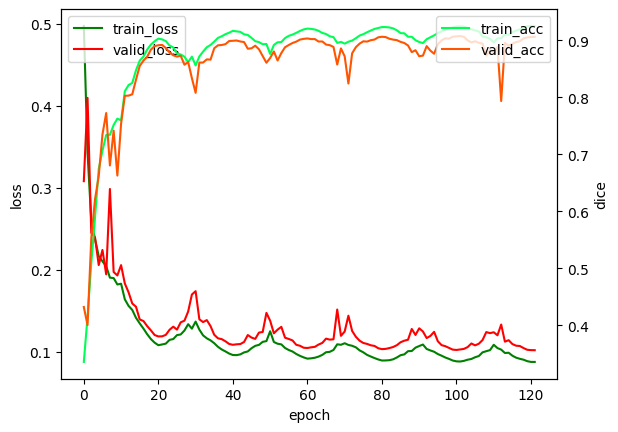

<Figure size 640x480 with 0 Axes>

In [21]:
train_loss,train_dice,valid_loss,valid_dice = train(
    training_data_loader=training_data_loader,
    validation_data_loader=validation_data_loader,
    model=model,
    epochs=epochs,
    criterion=criterion,
    optimizer=optimizer,
    scheduler = scheduler,
    n_classes=n_classes,
    EARLY_STOP = EARLY_STOP
)

plot_statistics(train_loss,train_dice,valid_loss,valid_dice,'dice',SAVE_MODELS_PATH)

In [22]:
SAVE_MODELS_PATH = f'H:\\NCNU\\class\\111-2_code\\2.DL\\111-2 DL HW\\TermProject\\weights\\U_net_CyclicLR_dice_loss'
SAVE_MODELS_PATH = f'H:\\NCNU\\class\\111-2_code\\2.DL\\111-2 DL HW\\TermProject\\weights\\SE_U_net_CyclicLR_dice_loss'
'''
model = U_net(n_channels=1,
                n_classes=n_classes,
                bilinear=True).to(device)
'''
model = SE_U_net(n_channels=1,
                n_classes=n_classes,
                mode='avg_pool',
                bilinear=True).to(device)
'''
model = CBAM_U_net_only_scout(n_channels=1,
                n_classes=n_classes,
                bilinear=True).to(device)

model = SE_U_net_only_scout(n_channels=1,
                n_classes=n_classes,
                mode='avg_pool',
                bilinear=True).to(device)

model = SE_U_net_Encoder_CBAM_U_net_scout(n_channels=1,
                n_classes=n_classes,
                mode='avg_pool',
                bilinear=True).to(device)
'''

#model.load_state_dict(torch.load(f'{SAVE_MODELS_PATH}/epoch_14_trainLoss_0.1281_trainDICE_86.9_valLoss_0.1383_valDICE_86.49.pth'))#U-net
model.load_state_dict(torch.load(f'{SAVE_MODELS_PATH}/epoch_75_trainLoss_0.0958_trainDICE_91.42_valLoss_0.109_valDICE_90.07.pth'))#SE-Unet

<All keys matched successfully>

validdation data predict result

In [23]:
train_img,train_mask = next(iter(training_data_loader))
print(train_img.size())
print(train_mask.size())

valid_img,valid_mask = next(iter(validation_data_loader))
print(valid_img.size())
print(valid_mask.size())

model.eval()    #預測要把model變成eval狀態
mask_pred = model(valid_img.to(device))
mask_pred = torch.sigmoid(mask_pred)
print(torch.max(mask_pred))

torch.Size([16, 1, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224])
torch.Size([16, 3, 224, 224])
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)


In [24]:
mask_pred_numpy = mask_pred.detach().cpu().numpy()
valid_img_numpy = valid_img.detach().cpu().numpy()
valid_mask_numpy = valid_mask.detach().cpu().numpy()

In [25]:
import cv2
idx = 7
img_1 = valid_img_numpy[idx].transpose(1,2,0)

img_1 = img_1.squeeze(2)
img_1 = cv2.cvtColor(img_1,cv2.COLOR_GRAY2BGR)
print('img_1:',img_1.shape)
valid_mask_1 = valid_mask_numpy[idx].transpose(1,2,0)
print('valid_mask_1',valid_mask_1 .shape)
mask_1 = mask_pred_numpy[idx].transpose(1,2,0)
print('mask_1',mask_1.shape)

import cv2
mask_1 = (mask_1//np.max(mask_1))*255

_,img_th_c1 = cv2.threshold(mask_1[:,:,0],127,255,cv2.THRESH_BINARY)
_,img_th_c2 = cv2.threshold(mask_1[:,:,1],127,255,cv2.THRESH_BINARY)
_,img_th_c3 = cv2.threshold(mask_1[:,:,2],127,255,cv2.THRESH_BINARY)

img_th_c1 = cv2.cvtColor(img_th_c1,cv2.COLOR_GRAY2BGR)
print(img_th_c1.shape)
img_th_c2 = cv2.cvtColor(img_th_c2,cv2.COLOR_GRAY2BGR)
img_th_c3 = cv2.cvtColor(img_th_c3,cv2.COLOR_GRAY2BGR)

diver = np.ones_like(mask_1)[:,:5,:]
print(diver.shape)
con = np.concatenate([img_1,diver,
                      img_th_c1,diver,
                      img_th_c2,diver,
                      img_th_c3,diver,
                      mask_1,diver,
                      valid_mask_1,diver],axis=1)

cv2.imshow('con',con)
cv2.waitKey(0)
cv2.destroyAllWindows()

# cv2.imshow('pred',mask_1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# cv2.imshow('con',valid_mask_1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()



img_1: (224, 224, 3)
valid_mask_1 (224, 224, 3)
mask_1 (224, 224, 3)
(224, 224, 3)
(224, 5, 3)
